/tmp/ipykernel_19330/3741116278.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


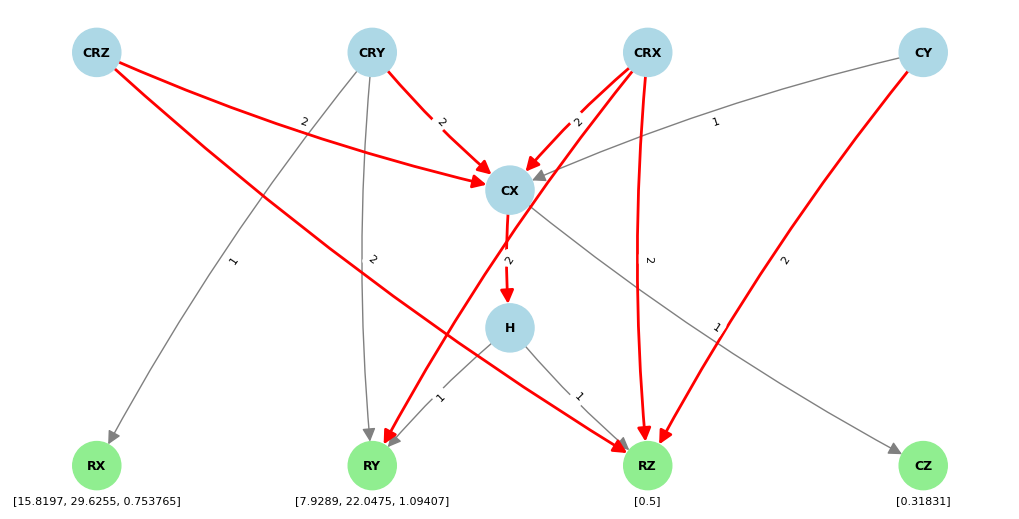

In [ ]:
import networkx as nx
import jax.numpy as jnp
import matplotlib.pyplot as plt
from qml_essentials.ansaetze import PulseParams
from qml_essentials.ansaetze import PulseInformation as PI


def build_pulse_graph(root: PulseParams) -> nx.DiGraph:
    """
    Build a directed graph of PulseParams dependencies.
    Nodes: PulseParams instances.
    Edges: parent -> child, with 'weight' being multiplicity.
    Node attributes:
        - 'name': gate name
        - 'params': string with parameters ('' for non-leaf)
        - 'is_leaf': bool
    Edge attributes:
        - 'weight': int
    """
    G = nx.DiGraph()

    stack = [root]
    visited = set()

    while stack:
        node = stack.pop()
        if node in visited:
            continue
        visited.add(node)

        # Node attributes
        if node.is_leaf:
            params_str = ", ".join(f"{float(x):.6g}" for x in node._params)
        else:
            params_str = ""

        if node not in G:
            G.add_node(
                node,
                name=node.name,
                params=params_str,
                is_leaf=node.is_leaf,
            )

        if not node.is_leaf:
            counts = {}
            for child in node.childs:
                counts[child] = counts.get(child, 0) + 1

            for child, w in counts.items():
                if G.has_edge(node, child):
                    G[node][child]["weight"] += w
                else:
                    G.add_edge(node, child, weight=w)

                if child not in visited:
                    stack.append(child)

    return G

def compute_leaf_distances(G: nx.DiGraph):
    """
    For each node, compute the maximum distance (in edges) to any leaf below it.
    This makes nodes with longer dependency chains appear higher in the tree.
    """
    # distance_to_leaf[node] = 0 for leaves
    distance_to_leaf = {n: 0 for n, d in G.nodes(data=True) if d.get("is_leaf")}

    # Process nodes in reverse topological order
    for n in reversed(list(nx.topological_sort(G))):
        if G.out_degree(n) == 0:
            continue  # leaf already has distance 0
        # max(1 + child distance)
        child_dists = [1 + distance_to_leaf[c] for c in G.successors(n)]
        distance_to_leaf[n] = max(child_dists)

    return distance_to_leaf

def hierarchical_pos_from_leaf_distance(G: nx.DiGraph, scale_x=1.0, scale_y=1.0):
    """
    Construct a 'tree-like' layout where:
      - y is proportional to distance from leaf (nodes with longest chains higher up)
      - x spreads siblings to avoid overlap.
    """
    # Compute "height" = distance from leaf
    dist = compute_leaf_distances(G)
    max_h = max(dist.values()) if dist else 0

    # Group nodes by height
    layers = {}
    for n, h in dist.items():
        layers.setdefault(h, []).append(n)

    # Assign x within each layer equally spaced
    pos = {}
    for h, nodes in sorted(layers.items()):  # from 0 (leaves) up
        k = len(nodes)
        if k == 1:
            xs = [0.0]
        else:
            xs = [i - (k - 1) / 2 for i in range(k)]
        for n, x in zip(nodes, xs):
            # y = h, with leaves at y=0, more complex gates higher (larger h)
            pos[n] = (x * scale_x, h * scale_y)

    return pos

def draw_pulse_graph(G: nx.DiGraph, figsize=(10, 5)):
    # Our custom hierarchical layout instead of graphviz/spring
    pos = hierarchical_pos_from_leaf_distance(G, scale_x=1.5, scale_y=1)

    plt.figure(figsize=figsize)

    # Node colors: leaf vs non-leaf
    node_colors = [
        "lightgreen" if G.nodes[n].get("is_leaf") else "lightblue"
        for n in G.nodes
    ]

    # Edge widths proportional to weight
    edge_weights = [G[u][v].get("weight", 1) for u, v in G.edges]
    max_w = max(edge_weights) if edge_weights else 1
    widths = [1 + 2 * (w - 1) / max_w for w in edge_weights]

    # Edge colors: highlight edges with weight > 1
    edge_colors = [
        "red" if G[u][v].get("weight", 1) > 1 else "gray"
        for u, v in G.edges
    ]

    # Draw nodes and edges
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_color=node_colors,
        node_size=1200,
        width=widths,
        edge_color=edge_colors,
        arrows=True,
        arrowsize=20,
        connectionstyle="arc3,rad=0.05",
    )

    # 1) Gate name labels (center of node)
    name_labels = {n: G.nodes[n]["name"] for n in G.nodes}
    nx.draw_networkx_labels(G, pos, labels=name_labels, font_size=9, font_weight="bold")

    # 2) Parameter labels, slightly below each node
    param_labels = {
        n: f"[{G.nodes[n]['params']}]" if G.nodes[n]["params"] else ""
        for n in G.nodes
    }
    # Shift y coordinate down a bit for params
    offset_pos = {n: (x, y - 0.25) for n, (x, y) in pos.items()}
    nx.draw_networkx_labels(G, offset_pos, labels=param_labels, font_size=8)

    # Edge labels: show weight if > 1
    edge_labels = {
        (u, v): G[u][v]["weight"]
        for u, v in G.edges
        if G[u][v].get("weight", 1)
    }
    

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Build global graph as before
top_roots = [PI.RX, PI.RY, PI.RZ, PI.CZ, PI.H, PI.CX, PI.CY, PI.CRX, PI.CRY, PI.CRZ]
G = nx.DiGraph()
for root in top_roots:
    Gi = build_pulse_graph(root)
    G = nx.compose(G, Gi)

draw_pulse_graph(G)

In [2]:
from qml_essentials.qoc import QOC
import csv
import matplotlib.pyplot as plt

qoc = QOC()
n_loops = qoc.n_loops
n_steps = qoc.n_steps
n_samples = qoc.n_samples

# optimize(gate="all", loops=5, make_log=True)

qoc_results = {}
with open("../qml_essentials/qoc_results.csv", "r") as f:
    reader = csv.reader(f)

    for row in reader:
        qoc_results[row[0]] = [float(x) for x in row[2:]]

qoc_logs = {}
with open("../qml_essentials/qoc_logs.csv", "r") as f:
    reader = csv.DictReader(f)
    qoc_logs = {field: [] for field in reader.fieldnames}

    for row in reader:
        for field in reader.fieldnames:
            val = float(row[field])
            qoc_logs[field].append(val)


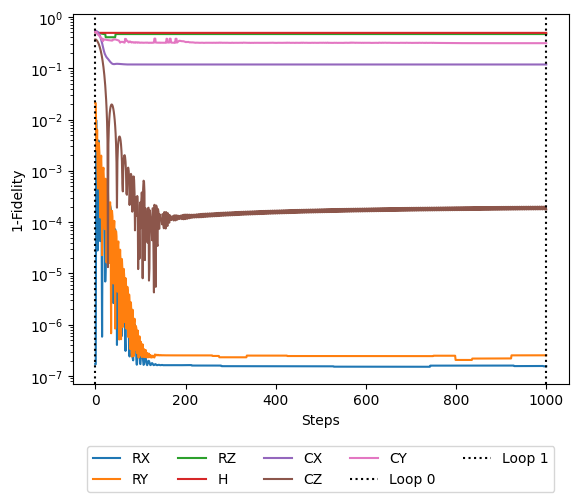

In [3]:
fig, ax = plt.subplots()

# for each gate, plot the fidelity
for gate, fidelities in qoc_logs.items():
    ax.plot(fidelities, label=gate)

for loop in range(n_loops + 1):
    plt.axvline(x=n_steps*loop, color='k', ls=':', label=f"Loop {loop}")

ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("Steps")
ax.set_ylabel("1-Fidelity")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=False, ncol=5)

plt.show()

In [4]:
from qml_essentials.ansaetze import PulseInformation
import pennylane as qml
import jax
from jax import numpy as jnp
jax.config.update("jax_enable_x64", True)

gates = ["CX", "CY", "CZ"]

# PulseInformation.update_params("../qml_essentials/qoc_results.csv")

results = {}
for gate in gates:
    pulse_circuit, target_circuit = getattr(qoc, "create_" + gate)()

    dev = qml.device("default.qubit", wires=2)
    pulse_qnode = qml.QNode(pulse_circuit, dev, interface="jax")
    target_qnode = qml.QNode(target_circuit, dev, interface="jax")

    results[gate] = {"pulse": {"x": [], "y": [], "z": []}, "target": {"x": [], "y": [], "z": []}}

    ws = jnp.arange(0, 2 * jnp.pi, (2 * jnp.pi) / n_samples)
    for i, w in enumerate(ws): 
        print(f"\rSimulating {gate} gate - Parameter sweep {i+1}/{n_samples}", end="")

        res = pulse_qnode(w, PulseInformation.gate_by_name(gate).params)
        results[gate]["pulse"]["x"].append(res[0].item())
        results[gate]["pulse"]["y"].append(res[1].item())
        results[gate]["pulse"]["z"].append(res[2].item())

        res = target_qnode(w)
        results[gate]["target"]["x"].append(res[0].item())
        results[gate]["target"]["y"].append(res[1].item())
        results[gate]["target"]["z"].append(res[2].item())

    print("")

Simulating CX gate - Parameter sweep 8/8
Simulating CY gate - Parameter sweep 8/8
Simulating CZ gate - Parameter sweep 8/8


/home/lc3267/Documents/CodeWorkspace/qml-essentials/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/lc3267/Documents/CodeWorkspace/qml-essentials/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/lc3267/Documents/CodeWorkspace/qml-essentials/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/lc3267/Documents/CodeWorkspace/qml-essentials/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/lc3267/Documents/CodeWorkspace/qml-essentials/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Cas

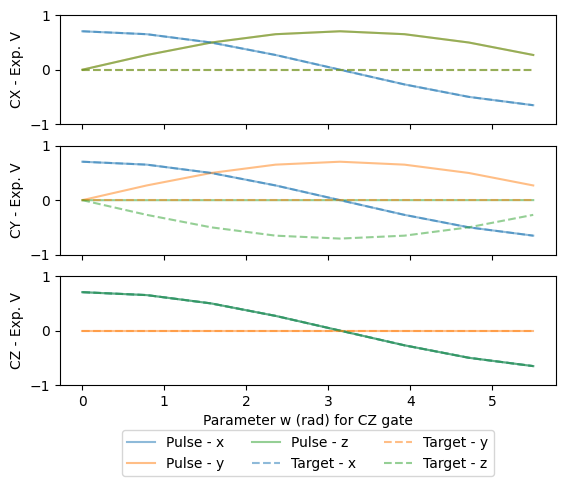

In [5]:
fig, axs = plt.subplots(len(gates), 1)

for i, gate in enumerate(gates):
    colors = iter(["C0", "C1", "C2"])
    for basis, expval in results[gate]["pulse"].items():
        axs[i].plot(ws, expval, linestyle="-", label=f"Pulse - {basis}", color=next(colors), alpha=0.5)

    colors = iter(["C0", "C1", "C2"])
    for basis, expval in results[gate]["target"].items():
        axs[i].plot(ws, expval, linestyle="--", label=f"Target - {basis}", color=next(colors), alpha=0.5)

    axs[i].set_ylabel(f"{gate} - Exp. V")
    axs[i].set_ylim(-1.0, 1.0)

    if i == len(gates) - 1:
        axs[i].set_xlabel(f"Parameter w (rad) for {gate} gate")
        axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
            fancybox=True, shadow=False, ncol=3)
    else:
        axs[i].set_xticklabels([])

plt.show()